In [156]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import time

In [157]:
jax.config.update("jax_enable_x64", True)

In [158]:
class PotentialFlow_Solver(object):
    def __init__(self, num_pts, boundary_list):
        self.num_pts = num_pts
        self.x = jnp.linspace(0, 4, num_pts)
        self.grid = jnp.stack(jnp.meshgrid(self.x, self.x, indexing='ij'))
        self.delta = self.x[1] - self.x[0]
        self.inner_boundary = self.find_boundary(boundary_list)

        self.whole_boundary = self.inner_boundary
        self.whole_boundary = self.whole_boundary.at[0, :].set(True)
        self.whole_boundary = self.whole_boundary.at[-1, :].set(True)
        self.whole_boundary = self.whole_boundary.at[:, 0].set(True)
        self.whole_boundary = self.whole_boundary.at[:, -1].set(True)

        active_r, active_c = jnp.where(~self.whole_boundary)
        self.active_idx = jnp.stack([active_r, active_c], axis=1)

    def find_boundary(self, boundary_list):
        mask = jnp.zeros((self.num_pts, self.num_pts), dtype=bool)
        for i in range(boundary_list.shape[0]):
            center = boundary_list[i, :-1]
            radius = boundary_list[i, -1]
            dist_sq = jnp.sum((self.grid - center[:, None, None])**2, axis=0)
            mask = jnp.logical_or(mask, dist_sq <= radius**2)
        return mask

    # We separate the "Solver Core" to JIT compile just the loop part.
    # We must pass 'active_idx' in because JAX needs to know loop lengths at compile time.
    @partial(jax.jit, static_argnames=['self', 'max_iter'])
    def _solve_core(self, u,  w, max_iter):
        
        # The Step Function: What happens for ONE pixel update
        def update_pixel(u, idx_pair, boundary=self.inner_boundary):
            r, c = idx_pair
            
            val_up    = jax.lax.cond(boundary[r-1,c], lambda _:u[r,c], lambda _:u[r-1,c], None)
            val_down  = jax.lax.cond(boundary[r+1,c], lambda _:u[r,c], lambda _:u[r+1,c], None)
            val_left  = jax.lax.cond(boundary[r,c-1], lambda _:u[r,c], lambda _:u[r,c-1], None)
            val_right = jax.lax.cond(boundary[r,c+1], lambda _:u[r,c], lambda _:u[r,c+1], None)
            
            gs_est = 0.25 * (val_up + val_down + val_left + val_right)
            new_val = (1 - w) * u[r, c] + w * gs_est
            
            # In-place update using .at[].set()
            u = u.at[r, c].set(new_val)
            return u, None # scan requires a 'carry' (u) and 'output' (None)

        # The Iteration Body: One full sweep over the grid
        def sweep_fn(u_prev, _):
            # scan loops over 'active_idx', carrying 'u' along
            u_new, _ = jax.lax.scan(update_pixel, u_prev, self.active_idx)

            diff = jnp.abs(u_new - u_prev)
            return u_new, jnp.nansum(diff)

        # Run the outer loop (max_iter)
        u_final, residual = jax.lax.scan(sweep_fn, u, jnp.arange(max_iter))
        
        return u_final, residual

    def solve(self, w=1.0, max_iter=100):
        
        u = jax.random.uniform(jax.random.PRNGKey(0), (self.num_pts, self.num_pts), minval=-1, maxval=1)
        
        u = u.at[self.whole_boundary].set(self.grid[1][self.whole_boundary])
        u = u.at[self.inner_boundary].set(jnp.nan)

        return self._solve_core(u, w, max_iter)
    
    def get_velocity_field(self, solution):


        velocity = jnp.zeros((2,self.num_pts,self.num_pts))

        def update_pixel(velocity, idx_pair, u=solution, boundary=self.inner_boundary):
            r, c = idx_pair
            
            val_up    = jax.lax.cond(boundary[r-1,c], lambda _:u[r,c], lambda _:u[r-1,c], None)
            val_down  = jax.lax.cond(boundary[r+1,c], lambda _:u[r,c], lambda _:u[r+1,c], None)
            val_left  = jax.lax.cond(boundary[r,c-1], lambda _:u[r,c], lambda _:u[r,c-1], None)
            val_right = jax.lax.cond(boundary[r,c+1], lambda _:u[r,c], lambda _:u[r,c+1], None)

            u_x = (val_right - val_left) / (2*self.delta)
            u_y = (val_up - val_down) / (2*self.delta)

            velocity = velocity.at[0,r,c].set(u_x)
            velocity = velocity.at[1,r,c].set(u_y)
            
            return velocity, None # scan requires a 'carry' (u) and 'output' (None)
            
        velocity, _ = jax.lax.scan(update_pixel, velocity, self.active_idx)

        # --- Top Edge (Row 0) ---
        velocity = velocity.at[1, 0, :].set((solution[0, :] - solution[1, :]) / self.delta) 
        velocity = velocity.at[0, 0, 1:-1].set((solution[0, 2:] - solution[0, :-2]) / (2*self.delta))

        # --- Bottom Edge (Row -1) ---
        velocity = velocity.at[1, -1, :].set((solution[-2, :] - solution[-1, :]) / self.delta)
        velocity = velocity.at[0, -1, 1:-1].set((solution[-1, 2:] - solution[-1, :-2]) / (2*self.delta))

        # --- Left Edge (Col 0) ---
        velocity = velocity.at[0, :, 0].set((solution[:, 1] - solution[:, 0]) / self.delta)
        velocity = velocity.at[1, 1:-1, 0].set((solution[2:, 0] - solution[:-2, 0]) / (2*self.delta))

        # --- Right Edge (Col -1) ---
        velocity = velocity.at[0, :, -1].set((solution[:, -1] - solution[:, -2]) / self.delta)
        velocity = velocity.at[1, 1:-1, -1].set((solution[2:, -1] - solution[:-2, -1]) / (2*self.delta))

        return velocity

In [159]:
boundary_list = 4*jnp.array([
        # [0.5, 0.5, 0.25],
        [0.25, 0.25, 0.125],
        [0.25, 0.75, 0.125],
        [0.75, 0.25, 0.125],
        [0.75, 0.75, 0.125]
])

solver = PotentialFlow_Solver(num_pts = 224, boundary_list=boundary_list)

In [160]:
_ = solver.solve(max_iter=2)

In [161]:
solution, residual=solver.solve(max_iter = 70000, w=1.5)
solution.block_until_ready()

Array([[0.        , 0.01793722, 0.03587444, ..., 3.96412556, 3.98206278,
        4.        ],
       [0.        , 0.01778427, 0.03556878, ..., 3.96443122, 3.98221573,
        4.        ],
       [0.        , 0.01763106, 0.03526262, ..., 3.96473738, 3.98236894,
        4.        ],
       ...,
       [0.        , 0.01763106, 0.03526262, ..., 3.96473738, 3.98236894,
        4.        ],
       [0.        , 0.01778427, 0.03556878, ..., 3.96443122, 3.98221573,
        4.        ],
       [0.        , 0.01793722, 0.03587444, ..., 3.96412556, 3.98206278,
        4.        ]], dtype=float64)

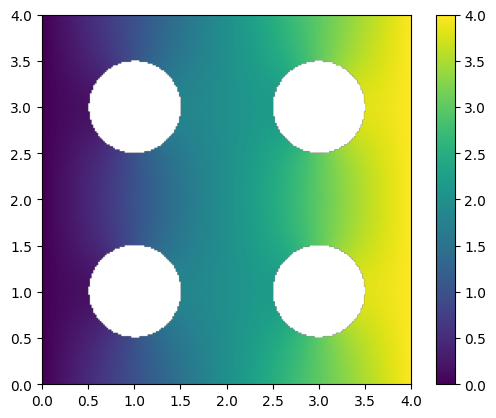

In [162]:
plt.imshow(solution,origin='lower',extent=[0,4,0,4])
plt.colorbar()
plt.show()

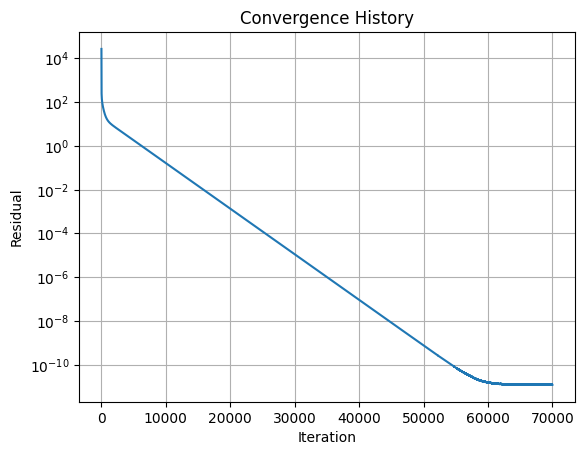

In [163]:
plt.semilogy(residual)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title('Convergence History')
plt.show()

In [164]:
velocity = solver.get_velocity_field(solution)

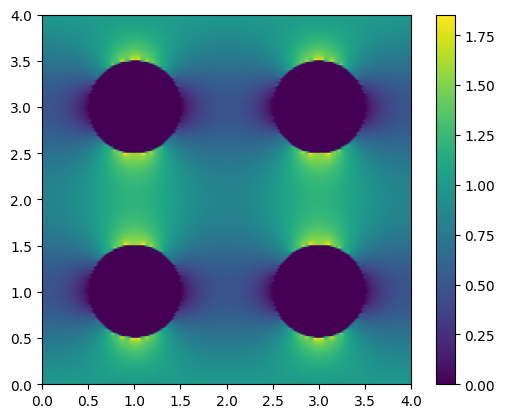

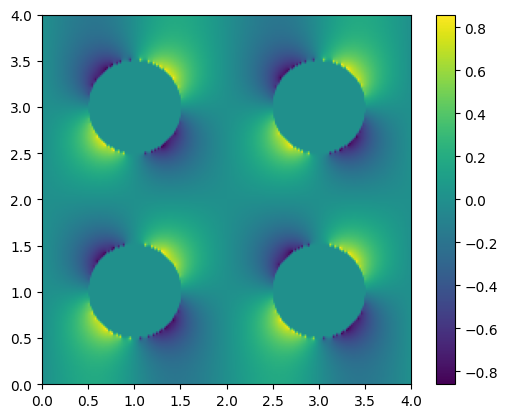

In [165]:
plt.imshow(velocity[0],extent=[0,4,0,4],origin='lower')
plt.colorbar()
plt.show()
plt.imshow(velocity[1],extent=[0,4,0,4],origin='lower')
plt.colorbar()
plt.show()

In [166]:
u_x = np.array(velocity[0])
u_y = np.array(velocity[1])
mask = np.isnan(u_x)
u_x[mask] = 0
u_y[mask] = 0


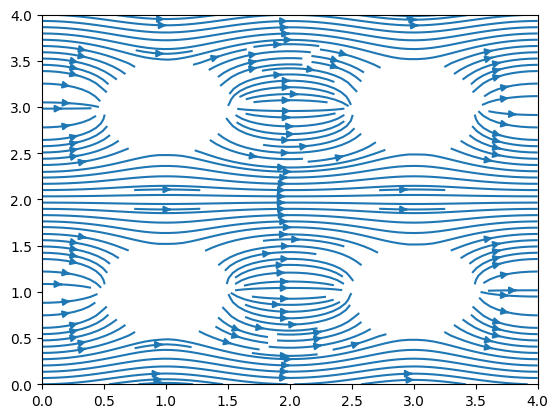

In [167]:
plt.streamplot(np.array(solver.grid[1]),np.array(solver.grid[0]),u_x, u_y,density=2)
plt.show()

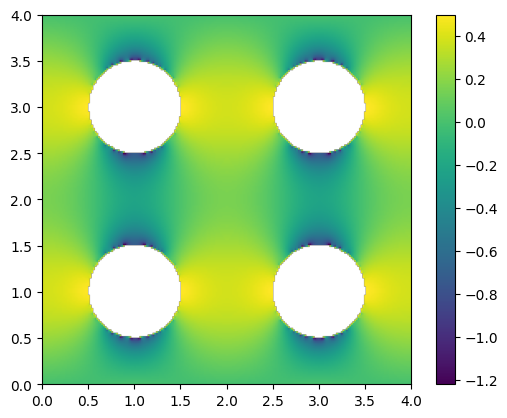

In [168]:
pressure = 0.5 - 0.5 * (u_x**2 + u_y**2)
pressure[solver.inner_boundary] = np.nan
plt.imshow(pressure,extent=[0,4,0,4],origin='lower')
plt.colorbar()
plt.show()